In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from yahoofinancials import YahooFinancials
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import math
from numpy import vstack,array 
from numpy.random import rand
import numpy as np 
from scipy.cluster.vq  import kmeans,vq 
import pandas as pd 
import pandas_datareader as dr 
import pandas_datareader.data as web 
from math import sqrt 
from sklearn.cluster import KMeans 
from matplotlib import pyplot as plt 
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from pycop import archimedean, estimation, mixture, gaussian, empirical
from statsmodels.distributions.empirical_distribution import ECDF
import sympy as sp
from sympy import symbols, diff
from scipy.stats import norm, multivariate_normal
from scipy.special import erfinv
from pycop.bivariate.copula import copula
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

## Train

In [2]:
def setup(pair_name, time):
    if len(pair_name) == 2:
        df = yf.download(pair_name,start = time[0],end = time[1])['Close']
        df = df.dropna()
        dfx = df[pair_name[0]]
        dfy = df[pair_name[1]]
    else:
        df = yf.download(pair_name,start = time[0],end = time[1])['Close']
        df = df.dropna()
        dfx = df[pair_name[0]]
        dfy = df[pair_name[1]]*df[pair_name[2]]

    ecdf_x = ECDF(dfx) #Get the empirical CDF from the given price list
    ecdf_y = ECDF(dfy)

    df['X_uniform'] = ecdf_x(dfx) # convert the price distribution to uniform distribution based on ecdf
    df['Y_uniform'] = ecdf_y(dfy)
    df['X_uniform'] = df['X_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])
    df['Y_uniform'] = df['Y_uniform'].replace([0.00, 1.00],[0.000001, 0.999999])

    ax1 = df.plot.scatter(x='X_uniform',y='Y_uniform',s=5)
    return df

In [3]:
# all the usual copula cdf and pdf equation
def clayton_pdf(u, v, param):
    term1 = (param + 1) * (u * v) ** (-param - 1)
    term2 = (u ** (-param) + v ** (-param) - 1) ** (-2 - 1 / param)
    return term1 * term2

def clayton_cdf(u, v, param):
    return (u ** (-param) + v ** (-param) - 1) ** (-1 / param)

def gumbel_pdf(u,v,param):
    term1 = (u*v)**(-1)
    tmp = (-sp.log(u))** param + (-sp.log(v))** param
    term2 = tmp ** (-2 + 2.0 / param)
    term3 = (sp.log(u) * sp.log(v)) ** (param - 1)
    term4 = 1 + (param - 1) *  (tmp ** (-1 / param))
    return gumbel_cdf(u,v, param) * term1 * term2 * term3 * term4

def gumbel_cdf(u, v, param):
    return sp.exp(-((-sp.log(u)) ** param + (-sp.log(v)) ** param ) ** (1 / param))

def frank_pdf(u,v, param):
    term1 = param * (1 - sp.exp(-param)) * sp.exp(-param * (u + v))
    term2 = (1 - sp.exp(-param) - (1 - sp.exp(-param * u)) \
                    * (1 - sp.exp(-param * v))) ** 2
    return term1 / term2

def frank_cdf(u,v,param):
    a = (sp.exp(-param * u) - 1) * (sp.exp(-param * v) - 1)
    return (-1 / param) * sp.log(1 + a / (sp.exp(-param) - 1))

def joe_pdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    term1 = (u_ + v_ - u_ * v_) ** (-2 + 1 / param)
    term2 = ((1 - u) ** (param - 1)) * ((1 - v) ** (param - 1))
    term3 = param - 1 + u_ + v_ + u_ * v_
    return term1 * term2 * term3

def joe_cdf(u,v,param):
    u_ = (1 - u) ** param
    v_ = (1 - v) ** param
    return 1 - (u_ + v_ - u_ * v_) ** (1 / param)

def galambos_pdf(u,v,param):
    x = -sp.log(u)
    y = -sp.log(v)
    term1 = galambos_cdf(u, v, param) / (v * u)
    term2 = 1 - ((x ** (-param) + y ** (-param)) ** (-1 - 1 / param)) \
                    * (x ** (-param - 1) + y ** (-param - 1))
    term3 = ((x ** (-param) + y ** (-param)) ** (-2 - 1 / param)) \
                    * ((x * y) ** (-param - 1))
    term4 = 1 + param + ((x ** (-param) + y ** (-param)) ** (-1 / param))
    return term1 * term2 + term3 * term4

def galambos_cdf(u,v,param):
    return u * v * sp.exp(((-sp.log(u)) ** (-param[0]) + (-sp.log(v)) ** (-param[0])) ** (-1 / param[0]) )

def fgm_pdf(u,v,param):
    return 1 + param * (1 - 2 * u) * (1 - 2 * v)

def fgm_cdf(u,v,param):
    return u * v * (1 + param * (1 - u) * (1 - v))

def plackett_pdf(u,v,param):
    eta = (param - 1)
    term1 = param * (1 + eta * (u + v - 2 * u * v))
    term2 = (1 + eta * (u + v)) ** 2 
    term3 = 4 * param * eta * u * v
    return term1 / (term2 - term3) ** (3 / 2)

def plackett_cdf(u,v,param):
    eta = param - 1
    term1 = 0.5 * eta ** -1
    term2 = 1 + eta * (u + v)
    term3 = (1 + eta * (u + v)) ** 2
    term4 = 4 * param * eta * u * v
    return term1 * (term2 - (term3 - term4) ** 0.5)

def rclayton_pdf(u,v,param):
    return clayton_pdf(1-u,1-v,param)

def rclayton_cdf(u,v,param):
    return (u + v - 1 + clayton_cdf((1 - u),(1 - v), param) )

def gaussian_pdf(u,v,param):
    rho = param
    a = np.sqrt(2) * erfinv(2 * u - 1)
    b = np.sqrt(2) * erfinv(2 * v - 1)
    det_rho = 1 - rho**2
    return det_rho**-0.5 * sp.exp(-((a**2 + b**2) * rho**2 -2 * a * b * rho) / (2 * det_rho))

def gaussian_cdf(u,v,param):
    y1 = norm.ppf(u, 0, 1)
    y2 = norm.ppf(v, 0, 1)
    rho = param
    return multivariate_normal.cdf((y1,y2), mean=None, cov=[[1, rho], [rho, 1]])

def scad_derivative(beta_hat, lambda_val, a_val):
    if abs(beta_hat) <= lambda_val:
        return lambda_val
    elif lambda_val < abs(beta_hat) <= a_val* lambda_val:
        return ((a_val*lambda_val) - beta_hat)/(a_val-1)
    elif abs(beta_hat) > a_val*lambda_val:
        return 0

In [4]:
def single_cop(df, pair_name, cop_name):
    param = []
    
    data = df[pair_name].T.values
    cop1 = archimedean(family= cop_name[0])
    param1, cmle = estimation.fit_cmle(cop1, data)
    print("Estimated parameter: ", param1[0])
    param.append(param1[0])

    cop2 = archimedean(family=cop_name[1])
    param2, cmle = estimation.fit_cmle(cop2, data)
    print("Estimated parameter: ", param2[0])
    param.append(param2[0])

    cop3 = archimedean(family=cop_name[2])
    param3, cmle = estimation.fit_cmle(cop3, data)
    print("Estimated parameter: ", param3[0])
    param.append(param3[0])
    
    return param


In [5]:
# initial values of theta for each copula are generated above to calculate the E-step

## Finding Thetas and Parameters

In [6]:
# If pycop failed, continue with numerical estimation

In [7]:
def pycop_find(df, pair_name, cop_name):
    cop = mixture(["clayton", "gumbel", "joe"])
    data = df[pair_name].T.values
    param, mle = estimation.fit_cmle_mixt(cop, data)
    return param    
        
def numerical(df, lamda, alpha, param):
           
    w1 = 0.333 # assign initial w1,w2,w3 and try to converge w1 first
    w2 = 0.333
    w3 = 0.334
    theta1 = param[0]
    theta2 = param[1]
    theta3 = param[2]
        
    param1 = []
    
    logsum1 = 0
    ## use sympy package to find out the derivative of the pdf of clayton copula
    x, y, z = symbols('x y z', real = True)
    f = clayton_pdf(x, y, z)
    dfdz = diff(f,z)

    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum1 = logsum1 + w1*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*clayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f1 = logsum1
    dfdtheta1 = diff(f1 , a) #f'(theta)
    
    logsum2 = 0
    x, y, z = symbols('x y z', real = True)
    f = gumbel_pdf(x, y, z)
    dfdz = diff(f,z)
    
    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum2 = logsum2 + w2*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*clayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*joe_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f2 = logsum2
    dfdtheta2 = diff(f2 , a)
    
    logsum3 = 0
    x, y, z = symbols('x y z', real = True)
    f = joe_pdf(x, y, z)
    dfdz = diff(f,z)
    
    a = symbols('a', real = True)
    for i in range(len(df)):
        logsum3 = logsum3 + w3*dfdz.subs([(x, df['X_uniform'][i]),(y, df['Y_uniform'][i]),(z,a)]) / (w1*clayton_pdf(df['X_uniform'][i],df['Y_uniform'][i],a) + w2*gumbel_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta2) + w3*frank_pdf(df['X_uniform'][i],df['Y_uniform'][i],theta3))
    f3 = logsum3
    dfdtheta3 = diff(f3 , a)

    
    iteration = 0
    for j in range(3):
        iteration += 1
        print(iteration, 'Round of Iteration')
        sumterm = 0
        wisumterm = 0
        for i in range(1000):
            for t in range(len(df)):
                sumterm = sumterm + (w1 * clayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1))/(w1*clayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1) + w2*gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2) + w3*frank_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta3))
            wisumterm = w1*scad_derivative(w1,lamda,alpha) + w2*scad_derivative(w2,lamda,alpha) + w3*scad_derivative(w3,lamda,alpha) - 1
            w1_new = (w1*scad_derivative(w1, lamda, alpha) - sumterm/len(df)) / wisumterm
            print('Weight 1 is converging: ', w1_new)
            if abs(w1_new - w1) <= 0.000001:
                w1 = w1_new
                sumterm = 0
                wisumterm = 0
                param1.append(w1)
                break
            else:
                sumterm = 0
                wisumterm = 0
                w1 = w1_new
    
    
        for i in range(1000):
            for t in range(len(df)):
                sumterm = sumterm + (w2 * gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2))/(w1*clayton_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta1) + w2*gumbel_pdf(df['X_uniform'][t],df['Y_uniform'][t],theta2) + w3*frank_pdf(df['X_uniform'][t],df['X_uniform'][t],theta3))
                wisumterm = w1*scad_derivative(w1,lamda,alpha) + w2*scad_derivative(w2,lamda,alpha) + w3*scad_derivative(w3,lamda,alpha) -1
            w2_new = (w2*scad_derivative(w2, lamda, alpha) - sumterm/len(df)) / wisumterm
            print('Weight 2 is converging: ', w2_new)
            if abs(w2_new - w2) <= 0.000001:
                sumterm = 0
                wisumterm = 0
                w2 = w2_new
                param1.append(w2)
                break
            else:
                sumterm = 0
                wisumterm = 0
                w2 = w2_new
        w3 = 1 - w1 - w2
        param1.append(w3)
    
     
        for i in range(1000): # iterate 1000times using NR methond to find theta of first copula
            theta1_new = theta1 - f1.subs([(a,theta1)]) / dfdtheta1.subs([(a,theta1)])
            print('Theta1 is converging: ' , theta1_new)
            if abs(theta1_new - theta1) <= 0.000001:
                theta1 = theta1_new
                param1.append(theta1)
                break
            else:
                theta1 = theta1_new




        for i in range(1000):
            theta2_new = theta2 - f2.subs([(a,theta2)]) / dfdtheta2.subs([(a,theta2)])
            print('Theta2 is converging: ' , theta2_new)
            if abs(theta2_new - theta2) <= 0.000001:
                theta2 = theta2_new
                param1.append(theta2)
                break
            else:
                theta2 = theta2_new




        for i in range(1000):
            theta3_new = theta3 - f3.subs([(a,theta3)]) / dfdtheta3.subs([(a,theta3)])
            print('Theta3 is converging: ' , theta3_new)
            if abs(theta3_new - theta3) <= 0.000001:
                theta3 = theta3_new
                param1.append(theta3)
                break
            else:
                theta3 = theta3_new
    
    return param1


In [8]:
# weight*sp.exp(-((-sp.log(x))**theta_gumbel+(-sp.log(y))**theta_gumbel)**(1/theta_gumbel))   <--- gumbel part
# weight*sp.log(sp.exp(sp.log((sp.exp(-theta*x)-1)/(sp.exp(-theta)-1))+sp.log((sp.exp(-theta*y)-1)/(sp.exp(-theta)-1)))*(sp.exp(-theta)-1)+1)/(theta)  <--- Frank Part
# weight*(((x**(-theta)-1)/theta + (y**(-theta)-1)/theta)*theta + 1)**(-1/theta)   <--- Clayton Part
# weight*(1-(1-(sp.exp((sp.log(1-(1-x)**theta))+sp.log(1-(1-x)**theta)))**(1/theta)))  <-- Joe Part

## Finalize Mixed Copula

In [9]:
def finalizemix(df, param):
    x,y = symbols('x y', real = True) # finding the partial dirivative of the copula function
    f = param[0]*clayton_cdf(x,y,param[3]) + param[1]*gumbel_cdf(x,y,param[4]) + param[2]*joe_cdf(x,y,param[5])
    dfdx = diff(f, x) # partial derivative of Copula function with respect to x
    dfdy = diff(f, y) # partial derivative of Copula function with respect to x

    df['dfdx'] = " "
    df['dfdy'] = " "
    for i in range(len(df)): # substitue the uniform of two assets to the partial derivative function
        df['dfdx'][i] = dfdx.subs([(x,df['X_uniform'][i]),(y,df['Y_uniform'][i])])
        df['dfdy'][i] = dfdy.subs([(x,df['X_uniform'][i]),(y,df['Y_uniform'][i])])
    
    return df

## Trading Strategy

In [10]:
def tradstrat(df, upthreshold, lowerthreshold, exitthreshold, or_and):
    df['X_position'] = " "
    if or_and == or_and[0]:
        if df['dfdx'][0] >= upthreshold or df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold or df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold or df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold or df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold or df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold or df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1
    else:
        if df['dfdx'][0] >= upthreshold and df['dfdy'][0]<= lowerthreshold:
            df['X_position'][0] = 1
        elif df['dfdx'][0] <= lowerthreshold and df['dfdy'][0]>= upthreshold:
            df['X_position'][0] = -1
        else:
            df['X_position'][0] = 0

        for i in range(1,len(df)):
            if df['X_position'][i-1] == 0:
                if df['dfdx'][i] >= upthreshold and df['dfdy'][i]<= lowerthreshold:
                    df['X_position'][i] = 1
                elif df['dfdx'][i] <= lowerthreshold and df['dfdy'][i]>= upthreshold:
                    df['X_position'][i] = -1
                else:
                    df['X_position'][i] = 0
            elif df['X_position'][i-1] == 1:
                if df['dfdy'][i] >= exitthreshold and df['dfdx'][i] <= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = 1
            elif df['X_position'][i-1] == -1:
                if df['dfdy'][i] <= exitthreshold and df['dfdx'][i] >= exitthreshold:
                    df['X_position'][i] = 0
                else:
                    df['X_position'][i] = -1

    return df

In [11]:
#
#def ret(df):
 #   df['return'] = " "
  #  df['return'][0] = 0
   # shares = 100
    #for i in range(1, len(df)):
     #   df['return'][i] = df['return'][i-1] + (dfx[i] - dfx[i-1])*(dfy[i]/dfx[i])*shares*df['X_position'][i-1] + (dfy[i] - dfy[i-1])*shares*df['Y_position'][i-1]
    #df['return'].plot()
    #return df['return'][-1]
###

def ret(df, funds):
    initial_funds = funds
    test = df.copy()
    
    test.iloc[0,0]  = 0
    test.iloc[0,1]  = 0
    test.iloc[-1,1]  = 0
    test.iloc[-1,0]  = 0

    test['cumpl'] = " "
    test['cumpl'][0] = 0

    ratio = (dfy[0]/dfx[0])
    
    for i in range(1, len(test)):
        Xshares = funds / dfx.iloc[i]
        Yshares = funds / dfy.iloc[i]
#         if(test.iloc[i,0] - test.iloc[i-1,0] != 0):#If position change != 0, change ratio;otherwise keep it
#             ratio = (dfy[i]/dfx[i])
        test['cumpl'][i] = test['cumpl'][i-1] + (dfx[i] - dfx[i-1])*Xshares*test['X_position'].iloc[i-1] + (dfy[i] - dfy[i-1])*Yshares*test['Y_position'].iloc[i-1]
        funds += (dfx[i] - dfx[i-1])*Xshares*test['X_position'].iloc[i-1] + (dfy[i] - dfy[i-1])*Yshares*test['Y_position'].iloc[i-1]
    test['dret'] = test['cumpl'] / test['cumpl'].shift(1)
    test['cumpl'] = test['cumpl'] / initial_funds + 1
    return test

## Result (Rolling Model Update)

[*********************100%***********************]  3 of 3 completed
Estimated parameter:  2.875322061879869
Estimated parameter:  2.5809097348123893
Estimated parameter:  2.119555496846133
method: SLSQP - success: True : Optimization terminated successfully
Estimated parameter:  0.49185868769548835
Estimated parameter:  1.461616704364681
Estimated parameter:  1.0000000007385097
method: SLSQP - success: True : Optimization terminated successfully
Estimated parameter:  1.101259915299881
Estimated parameter:  2.0706924978741443
Estimated parameter:  1.1385357505060796
method: SLSQP - success: True : Optimization terminated successfully
Estimated parameter:  2.2396946430966644
Estimated parameter:  2.5752198930765995
Estimated parameter:  1.0
method: SLSQP - success: True : Optimization terminated successfully
Estimated parameter:  2.49848680076401
Estimated parameter:  2.06139727062
Estimated parameter:  1.0
method: SLSQP - success: True : Optimization terminated successfully
Estimated p

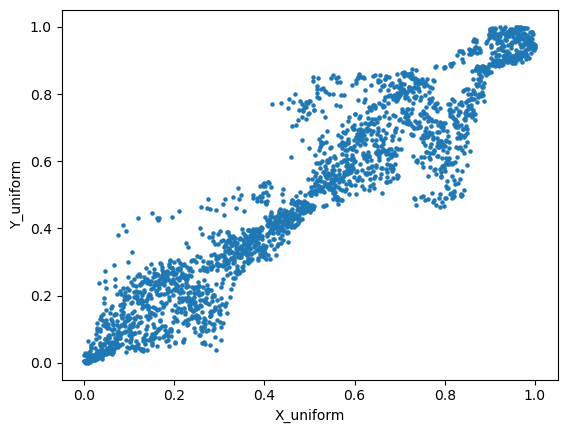

In [12]:
pair_name = ['IWM','1329.T', 'JPYUSD=X'] #AAPL is X and TSLA is Y
time = ['2013-02-07', '2023-01-20']
df = setup(pair_name, time)
df.index = pd.to_datetime(df.index)

upthreshold = 0.65
lowerthreshold = 0.35
exitthreshold = 0.5
or_and = ['or']
funds = 10000

lamda = 0.1
alpha = 1000000

position = np.array([])

for i in range(8):
    df_copy = df.copy()
    df_train = df_copy.loc[(df_copy.index.year >= 2013+i) & (df_copy.index.year <= 2015+i)]
    df_test = df_copy.loc[df_copy.index.year == 2016+i]
    
    cop_name = ['clayton', 'gumbel', 'joe']
    param = single_cop(df_train, pair_name, cop_name)
    try:
        param = pycop_find(df_train, pair_name, cop_name)
    except:
        param = numerical(lamda, alpha, param)
    df_test = finalizemix(df_test, param)
    df_test = tradstrat(df_test, upthreshold, lowerthreshold, exitthreshold, or_and)
    position = np.append(position, df_test['X_position'].to_numpy())



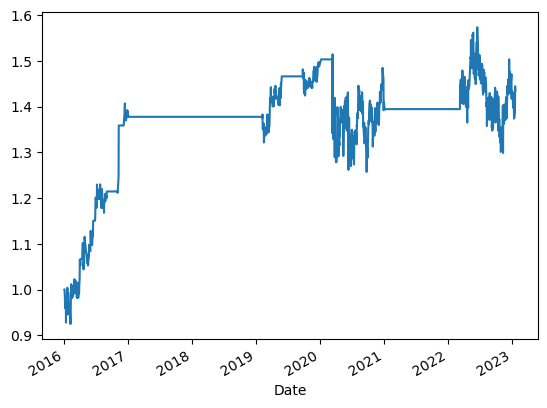

In [13]:
df_final = df.copy().loc[df.index.year >= 2016]
if len(pair_name) == 2:
    dfx = df_final[pair_name[0]]
    dfy = df_final[pair_name[1]]
else:
    dfx = df_final[pair_name[0]]
    dfy = df_final[pair_name[1]]*df_final[pair_name[2]]
if len(df_final) == len(position):
    df_final['X_position'] = position.tolist()
    df_final['Y_position'] = 0 - df_final['X_position']
    result = ret(df_final, funds)
    result['cumpl'].plot()


In [14]:
result_RUTN225 = result.copy()

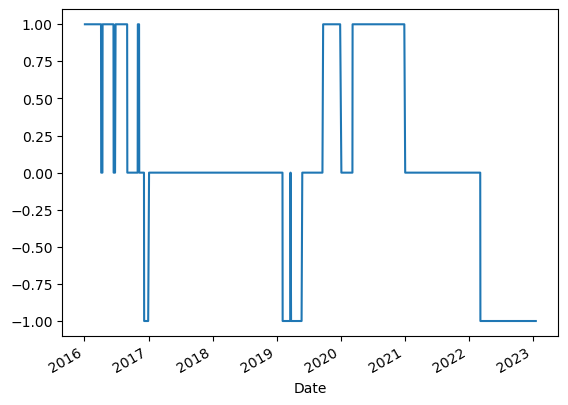

In [15]:
result_RUTN225['X_position'].plot()
plt.show()

[*********************100%***********************]  2 of 2 completed
Estimated parameter:  7.916085541324421
Estimated parameter:  2.675218272292224
Estimated parameter:  1.0000000000003197
method: SLSQP - success: True : Optimization terminated successfully
Estimated parameter:  1.5433715563402475
Estimated parameter:  2.395484590227131
Estimated parameter:  2.2944658903615953
method: SLSQP - success: True : Optimization terminated successfully
Estimated parameter:  2.43606610721875
Estimated parameter:  4.004796897545609
Estimated parameter:  5.782137986828418
method: SLSQP - success: False : Singular matrix E in LSQ subproblem
optimization failed
1 Round of Iteration
Weight 1 is converging:  0.310872998744948
Weight 1 is converging:  0.296454847173527
Weight 1 is converging:  0.286722828914230
Weight 1 is converging:  0.279996591113171
Weight 1 is converging:  0.275271398060347
Weight 1 is converging:  0.271913804828478
Weight 1 is converging:  0.269508575318993
Weight 1 is convergi

Weight 1 is converging:  0.0280210139789178
Weight 1 is converging:  0.0277438488629401
Weight 1 is converging:  0.0274788802330433
Weight 1 is converging:  0.0272254010888335
Weight 1 is converging:  0.0269827572667365
Weight 1 is converging:  0.0267503425894489
Weight 1 is converging:  0.0265275945403903
Weight 1 is converging:  0.0263139903980424
Weight 1 is converging:  0.0261090437741307
Weight 1 is converging:  0.0259123015072727
Weight 1 is converging:  0.0257233408702301
Weight 1 is converging:  0.0255417670544408
Weight 1 is converging:  0.0253672109002364
Weight 1 is converging:  0.0251993268451990
Weight 1 is converging:  0.0250377910665851
Weight 1 is converging:  0.0248822997967317
Weight 1 is converging:  0.0247325677929381
Weight 1 is converging:  0.0245883269455446
Weight 1 is converging:  0.0244493250098624
Weight 1 is converging:  0.0243153244492820
Weight 1 is converging:  0.0241861013783523
Weight 1 is converging:  0.0240614445958920
Weight 1 is converging:  0.02394

Weight 1 is converging:  0.0201056810208930
Weight 1 is converging:  0.0201044547423212
Weight 1 is converging:  0.0201032594760801
Weight 1 is converging:  0.0201020944343385
Weight 1 is converging:  0.0201009588494552
Weight 1 is converging:  0.0200998519734525
Weight 1 is converging:  0.0200987730775051
Weight 1 is converging:  0.0200977214514410
Weight 1 is converging:  0.0200966964032566
Weight 1 is converging:  0.0200956972586455
Weight 2 is converging:  0.556543451543989
Weight 2 is converging:  0.546072478424139
Weight 2 is converging:  0.542474483016854
Weight 2 is converging:  0.541218385328424
Weight 2 is converging:  0.540777444518450
Weight 2 is converging:  0.540622357212060
Weight 2 is converging:  0.540567772984810
Weight 2 is converging:  0.540548557034305
Weight 2 is converging:  0.540541791640008
Weight 2 is converging:  0.540539409664903
Weight 2 is converging:  0.540538571005055
Theta1 is converging:  15.3381249430064
Theta2 is converging:  14.8536142867361
Theta3 

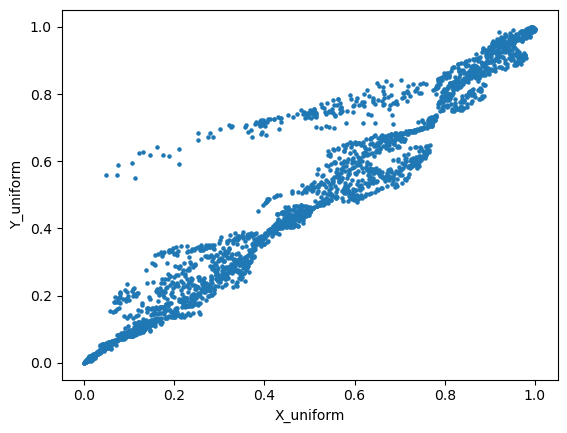

In [16]:
pair_name = ['IVOO','QQQ'] #AAPL is X and TSLA is Y
time = ['2013-02-07', '2023-01-20']
df = setup(pair_name, time)
df.index = pd.to_datetime(df.index)

upthreshold = 0.65
lowerthreshold = 0.35
exitthreshold = 0.5
or_and = ['or']
funds = 10000

lamda = 0.1
alpha = 1000000

position = np.array([])

for i in range(8):
    df_copy = df.copy()
    df_train = df_copy.loc[(df_copy.index.year >= 2013+i) & (df_copy.index.year <= 2015+i)]
    df_test = df_copy.loc[df_copy.index.year == 2016+i]
    
    cop_name = ['clayton', 'gumbel', 'joe']
    param = single_cop(df_train, pair_name, cop_name)
    try:
        param = pycop_find(df_train, pair_name, cop_name)
    except:
        param = numerical(df_train, lamda, alpha, param)
    df_test = finalizemix(df_test, param)
    df_test = tradstrat(df_test, upthreshold, lowerthreshold, exitthreshold, or_and)
    position = np.append(position, df_test['X_position'].to_numpy())



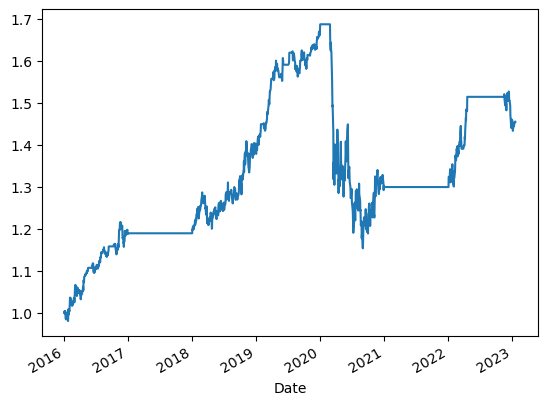

In [17]:
df_final = df.copy().loc[df.index.year >= 2016]
if len(pair_name) == 2:
    dfx = df_final[pair_name[0]]
    dfy = df_final[pair_name[1]]
else:
    dfx = df_final[pair_name[0]]
    dfy = df_final[pair_name[1]]*df_final[pair_name[2]]
if len(df_final) == len(position):
    df_final['X_position'] = position.tolist()
    df_final['Y_position'] = 0 - df_final['X_position']
    result = ret(df_final, funds)
    result['cumpl'].plot()


In [18]:
result_MIDNDX = result.copy()

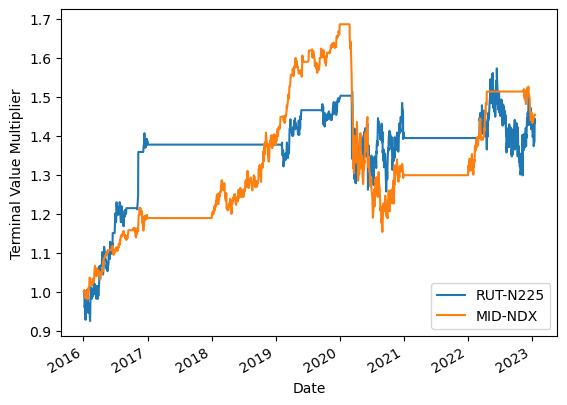

In [21]:
result_RUTN225['cumpl'].plot(ylabel='Terminal Value Multiplier', label = 'RUT-N225')
result_MIDNDX['cumpl'].plot(ylabel='Terminal Value Multiplier', label = 'MID-NDX')
leg = plt.legend(loc = 'lower right')
plt.show()